# 3D Instance Segmentation with Discriminative Instance Loss
---
Implemntation of paper:

[Semantic Instance Segmentation with a Discriminative Loss Function](https://arxiv.org/abs/1708.02551)

In [1]:
import os
import errno
import datetime

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the training data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'mousebrain.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.mousebrain.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

1730158592/1730150850 [==============================] - 33s 0us/step
X.shape: (176, 15, 256, 256, 1)
y.shape: (176, 15, 256, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'disc_fgbg'
disc_3d_model_name = 'disc_3d'

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'disc'
embedding_dim = 3

# 3D Settings
frames_per_batch = 3

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_3D(
    receptive_field=receptive_field,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_frames=frames_per_batch,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    multires=False,
    last_only=False,
    norm_method='whole_image')

#### Train the fgbg model

In [7]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=fgbg_model_name,
    frames_per_batch=frames_per_batch,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform='fgbg',
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/10
197/198 [============================>.] - ETA: 0s - loss: 0.9027 - model_loss: 0.2221 - model_1_loss: 0.2163 - model_2_loss: 0.2141 - model_3_loss: 0.2142 - model_acc: 0.9097 - model_1_acc: 0.9130 - model_2_acc: 0.9156 - model_3_acc: 0.9119
Epoch 00001: val_loss improved from inf to 0.88928, saving model to /data/models/disc_fgbg.h5
198/198 [==============================] - 132s 665ms/step - loss: 0.9007 - model_loss: 0.2215 - model_1_loss: 0.2158 - model_2_loss: 0.2137 - model_3_loss: 0.2138 - model_acc: 0.9098 - model_1_acc: 0.9132 - model_2_acc: 0.9156 - model_3_acc: 0.9120 - val_loss: 0.8893 - val_model_loss: 0.1977 - val_model_1_loss: 0.2150 - val_model_2_loss: 0.2200 - val_model_3_loss: 0.2207 - val_model_acc: 0.9289 - val_model_1_acc: 0.9399 - v

### Next, Create a model for the 3D vector embedding

#### Instantiate the discriminative loss model

In [8]:
from deepcell import model_zoo

disc_3d_model = model_zoo.bn_feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=embedding_dim,
    n_dense_filters=128,
    n_conv_filters=32,
    input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
    norm_method=norm_method)

#### Train the model

In [9]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=disc_3d_model_name,
    frames_per_batch=frames_per_batch,
    test_size=test_size,
    optimizer=optimizer,
    n_epoch=n_epoch,
    batch_size=batch_size,
    transform=transform,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (None, 3, 256, 256, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/10
197/198 [============================>.] - ETA: 0s - loss: 25.7492 - model_loss: 6.4300 - model_1_loss: 6.4259 - model_2_loss: 6.4321 - model_3_loss: 6.4255 - model_acc: 0.8357 - model_1_acc: 0.8347 - model_2_acc: 0.8364 - model_3_acc: 0.8298
Epoch 00001: val_loss improved from inf to 25.20974, saving model to /data/models/disc_3d.h5
198/198 [==============================] - 67s 338ms/step - loss: 25.7512 - model_loss: 6.4304 - model_1_loss: 6.4264 - model_2_loss: 6.4326 - model_3_loss: 6.4260 - model_acc: 0.8360 - model_1_acc: 0.8349 - model_2_acc: 0.8366 - model_3_acc: 0.8301 - val_loss: 25.2097 - val_model_loss: 6.2963 - val_model_1_loss: 6.2959 - val_model_2_loss: 6.2886 - val_model_3_loss: 6.2930 - val_model_acc: 0.8415 - val_model_1_acc: 0.8401 - 

### Run the model

In [10]:
# With the trained model, make predictions on testing data
test_images = disc_3d_model.predict(X_test[:1, :frames_per_batch])
test_images_fgbg = fgbg_model.predict(X_test[:1, :frames_per_batch])[-1]

print(test_images.shape)
print(test_images_fgbg.shape)

(1, 3, 256, 256, 3)
(1, 3, 256, 256, 2)


### Post-processing

#### Threshold the foreground/background

In [11]:
# threshold the foreground/background
# and remove background from vector embedding
fg_thresh = test_images_fgbg[..., 1] > 0.9
fg_thresh = np.expand_dims(fg_thresh, axis=-1)
test_images_post_fgbg = test_images * fg_thresh

#### Mean Shift

In [12]:
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth

def fit_mean_shift(images, index, frame, ndim, n_samples=500):
    test_plot = images[index, frame].reshape(-1, ndim)
    bandwidth = estimate_bandwidth(test_plot, n_samples=n_samples)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(test_plot)
    return ms

#### DB SCAN

In [13]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

def fit_dbscan(images, index, frame, ndim, eps=.15):
    test_plot = images[index, frame].reshape(-1, ndim)
    db = DBSCAN(eps=eps, min_samples=5, algorithm='kd_tree').fit(test_plot)
    return db

### Plot the results

#### Scatter plots of the embedded vectors

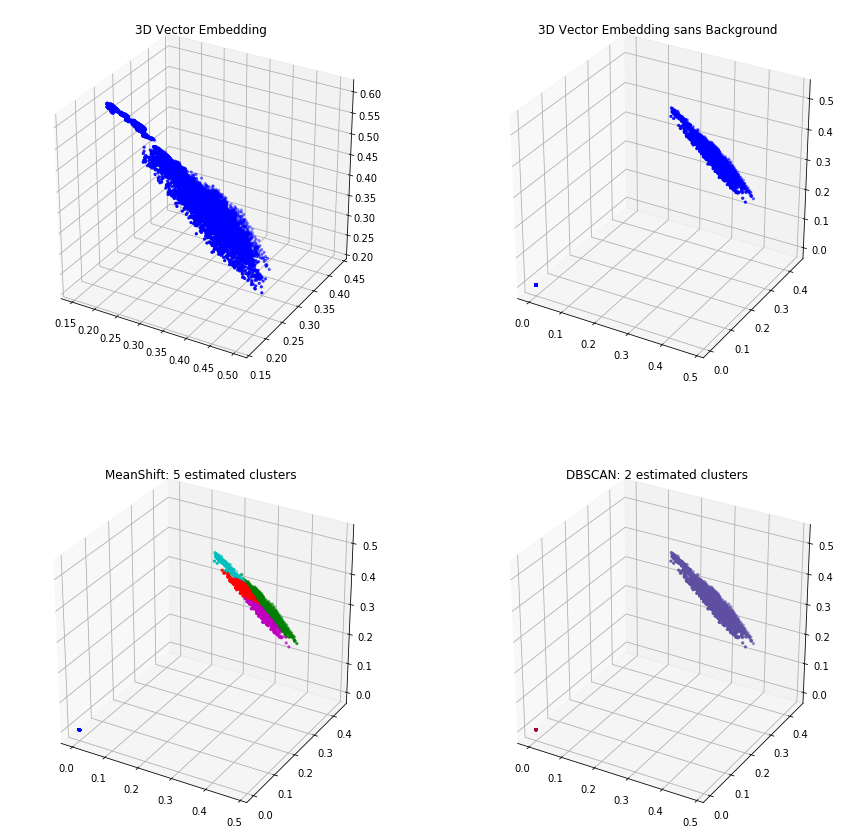

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

index = 0#np.random.randint(low=0, high=test_images_post_fgbg.shape[0])
frame = 2#np.random.randint(low=0, high=test_images_post_fgbg.shape[1])

fig = plt.figure(figsize=(15, 15))

# 3D Vector Embedding
ax = fig.add_subplot(221, projection='3d')
test_plot = test_images[index, frame].reshape(-1, embedding_dim)
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)
ax.set_title('3D Vector Embedding')

# 3D Vector Embedding sans Background
ax = fig.add_subplot(222, projection='3d')
test_plot = test_images_post_fgbg[index, frame].reshape(-1, 3)
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)
ax.set_title('3D Vector Embedding sans Background')

# Scatter plot after MeanShift
ms = fit_mean_shift(test_images_post_fgbg, index=index, frame=frame, ndim=embedding_dim, n_samples=2000)
n_clusters_ms = np.unique(ms.labels_).size
ax = fig.add_subplot(223, projection='3d')
for k, col in zip(range(n_clusters_ms), cycle('bgrcmyk')):
    my_members = ms.labels_ == k
    ax.scatter(test_plot[my_members, 0],
               test_plot[my_members, 1],
               test_plot[my_members, 2],
               c=col, s=5)
ax.set_title('MeanShift: %d estimated clusters' % n_clusters_ms)

# Scatter plot after DBSCAN
db = fit_dbscan(test_images_post_fgbg, index=index, frame=frame, ndim=embedding_dim, eps=0.2)
# Number of clusters in labels, ignoring noise if present.
n_clusters_db = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

ax = fig.add_subplot(224, projection='3d')

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Scatter plot after DBScan
unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black used for noise.

    class_member_mask = (db.labels_ == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=col, s=5)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=col, s=5)

ax.set_title('DBSCAN: %d estimated clusters' % n_clusters_db)

plt.show()

#### Plot segmented images

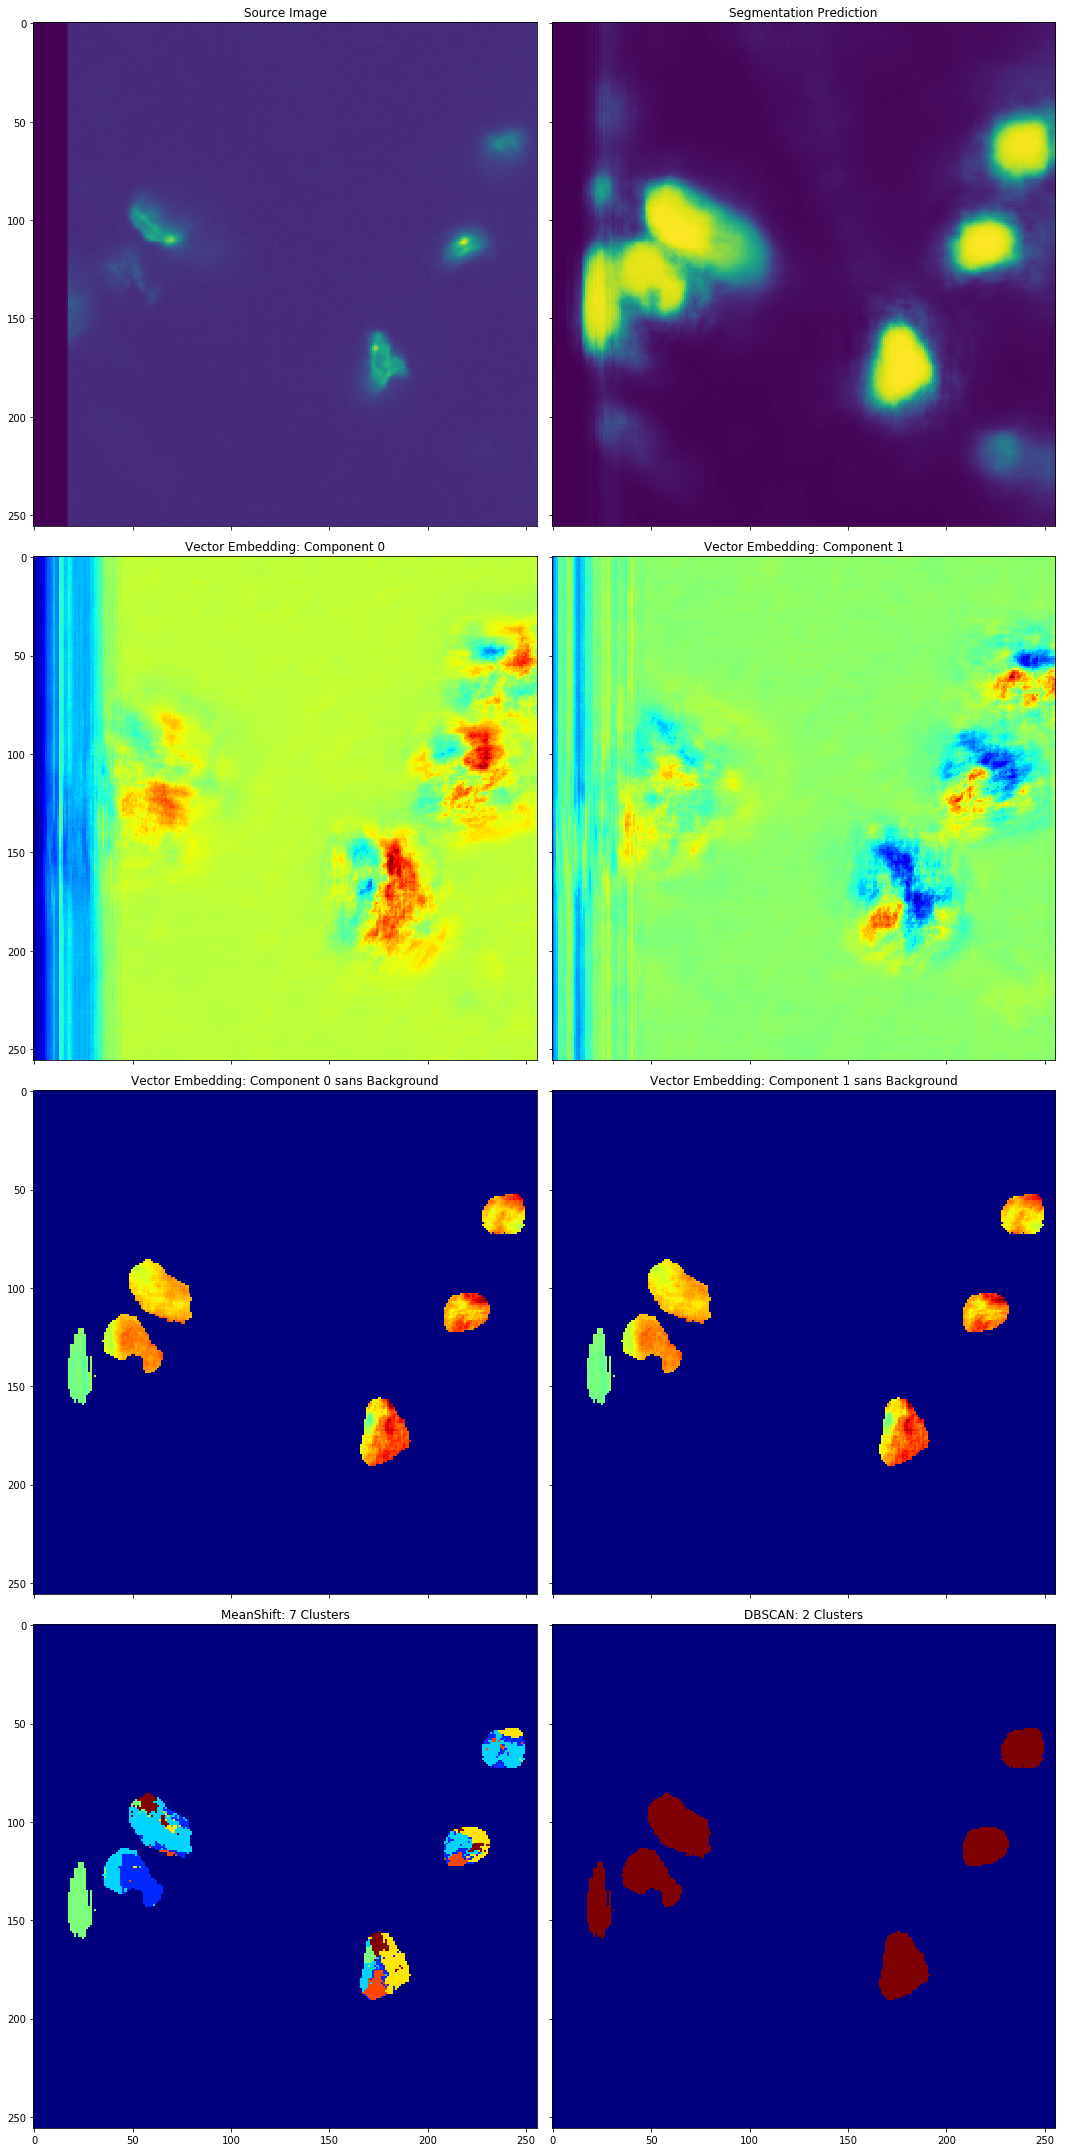

In [15]:
import matplotlib.pyplot as plt

index = 0#np.random.randint(low=0, high=test_images_post_fgbg.shape[0])
frame = 0#np.random.randint(low=0, high=test_images_post_fgbg.shape[1])

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images[index, frame, ..., 0], cmap='jet')
ax[2].set_title('Vector Embedding: Component 0')

ax[3].imshow(test_images[index, frame, ..., 1], cmap='jet')
ax[3].set_title('Vector Embedding: Component 1')

ax[4].imshow(test_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Vector Embedding: Component 0 sans Background')

ax[5].imshow(test_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Vector Embedding: Component 1 sans Background')

ms = fit_mean_shift(test_images_post_fgbg, index=index, frame=frame, ndim=3, n_samples=2000)
ax[6].imshow(ms.labels_.reshape(test_images_post_fgbg.shape[2:-1]), cmap='jet')
ax[6].set_title('MeanShift: %d Clusters' % np.unique(ms.labels_).size)

db = fit_dbscan(test_images_post_fgbg, index=index, frame=frame, ndim=3, eps=0.2)
ax[7].imshow(db.labels_.reshape(test_images_post_fgbg.shape[2:-1]), cmap='jet')
ax[7].set_title('DBSCAN: %d Clusters' % (len(set(db.labels_)) - int(-1 in db.labels_)))

fig.tight_layout()
plt.show()